In [1]:
# Import of required modules..
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

np.random.seed(10)
plt.ion()   # interactive mode

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data transformation for train, val and test datasets.
data_transforms = {
    'Training_dir': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(0,translate=(0.1,0.1),shear=1),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation_dir': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing_dir': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = ''
# Loader to load the training and valiadtion data sets from 'Training_dir','Validation_dir' directory for model training and validation.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training_dir', 'Validation_dir']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True,) for x in ['Training_dir', 'Validation_dir']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training_dir', 'Validation_dir']}
class_names = image_datasets['Training_dir'].classes

# Loader to load the testing data sets from 'Testing_dir' directory for model evaluation.
testset = datasets.ImageFolder(os.path.join(data_dir, 'Testing_dir'),data_transforms['Testing_dir'])
testloader = torch.utils.data.DataLoader(testset, batch_size=600,shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Function definition for model training, get model,loss function(criterion), optimizer ...
# ... scheduler to schedule the learning rate so it get smaller to speed up model divergence and number of epochs
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_history = np.zeros((2,num_epochs))# Used to track train and validation loss
    acc_history = np.zeros((2,num_epochs)) # Used to track train and validation accuracy

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training_dir', 'Validation_dir']:
            if phase == 'Training_dir':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward, track history if only in train
                with torch.set_grad_enabled(phase == 'Training_dir'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training_dir':
                        loss.backward()
                        optimizer.step()

                # loss and accuracy calculation
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Update learning rate.
            if phase == 'Training_dir':
                scheduler.step()

            # loss and accuracy calculation over entire epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'Training_dir':
                # First row is used to store training accuracy and loss
                loss_history[0][epoch] = epoch_loss
                acc_history[0][epoch] = epoch_acc
            else:
                # Second row is used to store validation accuracy and loss
                loss_history[1][epoch] = epoch_loss
                acc_history[1][epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # copy the best model
            if phase == 'Validation_dir' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Return trained model, accuracy and loss results
    return model, loss_history, acc_history

In [4]:
# Instantiate the model with pretrained weights for resnet50 neural network
model_ft = models.resnet50(pretrained=True)

# Count the number of input neurons to the last layer (2048)
num_ftrs = model_ft.fc.in_features

# Create the last layer with input of (2048), and output of (4).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Create the loss function --> cross entropy loss
criterion = nn.CrossEntropyLoss()

# Create the optimizer --> Stocastic Gradient Descent
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
# Traing the model for 100 epochs
model_ft,loss,acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

# Store the model
PATH = './model_net_resnet50.pth'
torch.save(model_ft.state_dict(), PATH)

Epoch 0/4
----------
Training_dir Loss: 1.1441 Acc: 0.5360
Validation_dir Loss: 0.8052 Acc: 0.7036

Epoch 1/4
----------
Training_dir Loss: 0.9828 Acc: 0.6340
Validation_dir Loss: 1.0293 Acc: 0.6464

Epoch 2/4
----------
Training_dir Loss: 0.8860 Acc: 0.6585
Validation_dir Loss: 0.8058 Acc: 0.7821

Epoch 3/4
----------
Training_dir Loss: 0.8523 Acc: 0.6860
Validation_dir Loss: 0.8162 Acc: 0.6964

Epoch 4/4
----------
Training_dir Loss: 0.7335 Acc: 0.7265
Validation_dir Loss: 0.6979 Acc: 0.7286

Training complete in 2m 50s
Best val Acc: 0.782143


In [6]:
# Model testing, we will have 150 images for each class (4 classes) == (600 images).
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        target = labels
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Total number of test images: {total}')
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Total number of test images: 600
Accuracy of the network on the test images: 76 %


In [7]:
# calculate and print the recall, precision and f1 score for model testing
print(classification_report(labels.cpu(), predicted.cpu()))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       150
           1       0.66      0.95      0.78       150
           2       0.74      0.93      0.82       150
           3       1.00      0.41      0.58       150

    accuracy                           0.76       600
   macro avg       0.81      0.76      0.74       600
weighted avg       0.81      0.76      0.74       600



In [8]:
# calculte and print the confusion matric
cm = confusion_matrix(target, predicted.cpu())
print(cm)

[[114  14  22   0]
 [  4 142   4   0]
 [  8   3 139   0]
 [  9  56  24  61]]


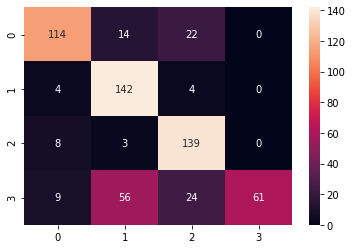

In [9]:
# Calculate and show the confusion matrix
hm = sns.heatmap(cm, annot=True,fmt="d")

In [10]:
# Get the train and validation loss and accuracy.
train_acc = acc[0,:]
val_acc = acc[1,:]
train_loss = loss[0,:]
val_loss = loss[1,:]

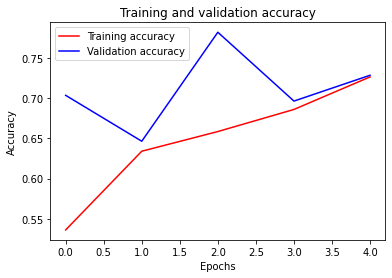

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the training and validation accuracy
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

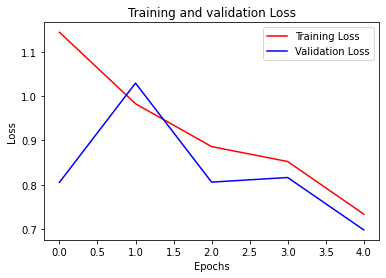

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the training and validation loss
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()

plt.show()